In [1]:

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from data_handler import DataHandler
from forecast import Forecast

/Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:

start_of_data = datetime(2023, 11, 1)
end_of_training_data = datetime(2024, 1, 5)
dataHandler = DataHandler(
    "localhost",
    "smart_home_formankovi",
    "root",
    "root",
    "shelly1pm_34945475a969",
    start_of_data,
)






In [4]:
from turtle import color


#plot data with x as datetimes_train


In [5]:
forecast = Forecast(dataHandler)
forecast.train_model(begin_of_training=start_of_data, end_of_training=end_of_training_data)
forecast.build_model()
forecast.fit_model()




Epoch 1/70


/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weekday"] = df.index.weekday
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df.index.hour
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

932/932 [==============================] - 3s 2ms/step - loss: 0.6555 - r2_keras: -177199.4219 - val_loss: 0.6223 - val_r2_keras: -1882380.5000
Epoch 2/70
 72/932 [=>............................] - ETA: 1s - loss: 0.4898 - r2_keras: -288725.1875

/Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


932/932 [==============================] - 2s 2ms/step - loss: 0.4131 - r2_keras: -156324.1094 - val_loss: 0.5543 - val_r2_keras: -2242107.2500
Epoch 3/70
932/932 [==============================] - 2s 2ms/step - loss: 0.3522 - r2_keras: -114844.7812 - val_loss: 0.4305 - val_r2_keras: -1021154.0625
Epoch 4/70
932/932 [==============================] - 2s 2ms/step - loss: 0.3377 - r2_keras: -91079.7109 - val_loss: 0.4993 - val_r2_keras: -1657267.0000
Epoch 5/70
932/932 [==============================] - 2s 2ms/step - loss: 0.3153 - r2_keras: -89064.4844 - val_loss: 0.4046 - val_r2_keras: -992342.0000
Epoch 6/70
932/932 [==============================] - 2s 2ms/step - loss: 0.3155 - r2_keras: -56174.4375 - val_loss: 0.4805 - val_r2_keras: -1534132.7500
Epoch 7/70
932/932 [==============================] - 2s 2ms/step - loss: 0.3078 - r2_keras: -58861.2031 - val_loss: 0.4231 - val_r2_keras: -1183340.3750
Epoch 8/70
932/932 [==============================] - 2s 2ms/step - loss: 0.3076 - r2_

In [6]:
forecast_begin_date = datetime(2024, 1, 1, 0, 0, 0)
forecast_end_date = datetime(2024, 1, 2, 23, 59, 59)

y_pred, y_truth, statistics = forecast.get_forecast_next_steps(begin_date = forecast_begin_date, end_date = forecast_end_date)


prediction_data, datetimes_prediction = dataHandler.get_data_for_prediction(forecast_begin_date, forecast_end_date)

3/3 [==============================] - 0s 2ms/step


/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weekday"] = df.index.weekday
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df.index.hour
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [7]:
y_real_db = prediction_data['longtime_mean'].values

IndexError: index 48 is out of bounds for axis 0 with size 48

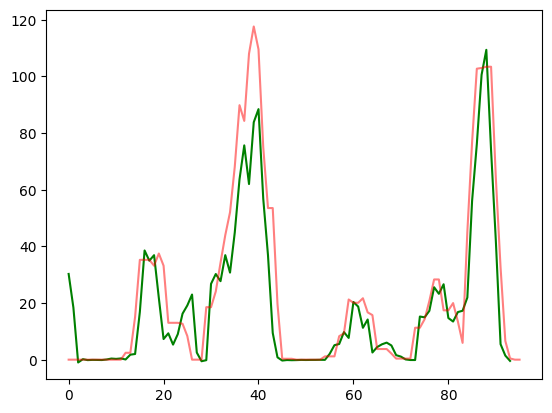

In [11]:

# plt.plot(y_truth)

plt.plot(y_pred, color = 'green', label = 'Predicted data')
plt.plot(y_real_db, color = 'red', label = 'Real data', alpha = 0.5)


dates = pd.date_range(forecast_begin_date, forecast_end_date, freq='1H')
dates = dates.strftime('%Y-%m-%d')
# set xticks to dates
plt.xticks(np.arange(0, y_real_db.shape[0], step=24), dates[np.arange(0, y_real_db.shape[0], step=24)], rotation=45)

# create list of dates by 1 hour from 2023-11-01 00:00:00 to 2023-11-30 23:00:00
start = pd.to_datetime('2023-12-16 19:00:00')

# add x and y label
plt.xlabel('Datum')
plt.ylabel('Spotřeba tepla [kJ]')
plt.show()

3/3 [==============================] - 0s 2ms/step


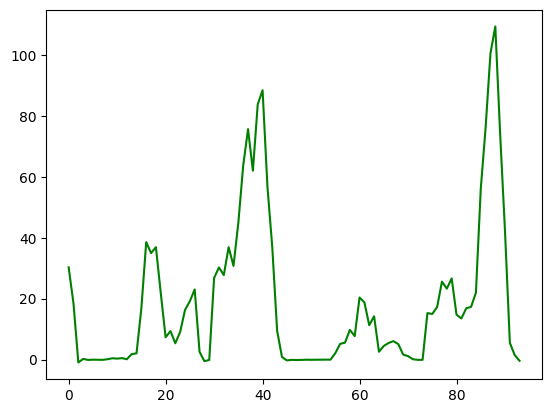

In [14]:
# create dataframe with column datetime from now to now+6hours and rows by 30 minutes

forecast_begin_date = datetime(2024, 1, 1, 0, 0, 0)
forecast_end_date = datetime(2024, 1, 2, 23, 59, 59)


df_predict = pd.DataFrame({'datetime': pd.date_range(forecast_begin_date, forecast_end_date, freq='30min')})
df_predict['longtime_mean'] = 0
df_predict['weekday_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
df_predict['weekday_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
df_predict['hour_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.hour / 24)
df_predict['hour_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.hour / 24)
df_predict['minute_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.minute / 60)
df_predict['minute_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.minute / 60)
# delete column datetime
df_predict = df_predict.drop(columns='datetime')
df_predict_trans = df_predict.copy()
df_predict_trans[df_predict.columns] = forecast.scaler.transform(df_predict)

predict_gen = forecast.generator(df_predict_trans, 'longtime_mean', 
                lookback = forecast.lookback,
                delay = forecast.delay,
                min_index = 0,
                max_index = None,
                step = 1,
                shuffle = False,
                batch_size = df_predict.shape[0])

(X_2, y_2) = next(predict_gen)

y_pred_2 = forecast.model.predict(X_2)
y_pred_2 = np.concatenate((y_pred_2,np.zeros((y_pred_2.shape[0],forecast.num_of_features))),axis=1)
y_pred_2 = forecast.scaler.inverse_transform(y_pred_2)
y_pred_2 = y_pred_2[:,0]

plt.plot(y_pred, color = 'green', label = 'Predicted data')
plt.show()